In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Explore Data Analysis

In [2]:
df = pd.read_csv('/content/sample_data/california_housing_train.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [3]:
df.shape

(17000, 9)

In [4]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
dtype: object

In [5]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

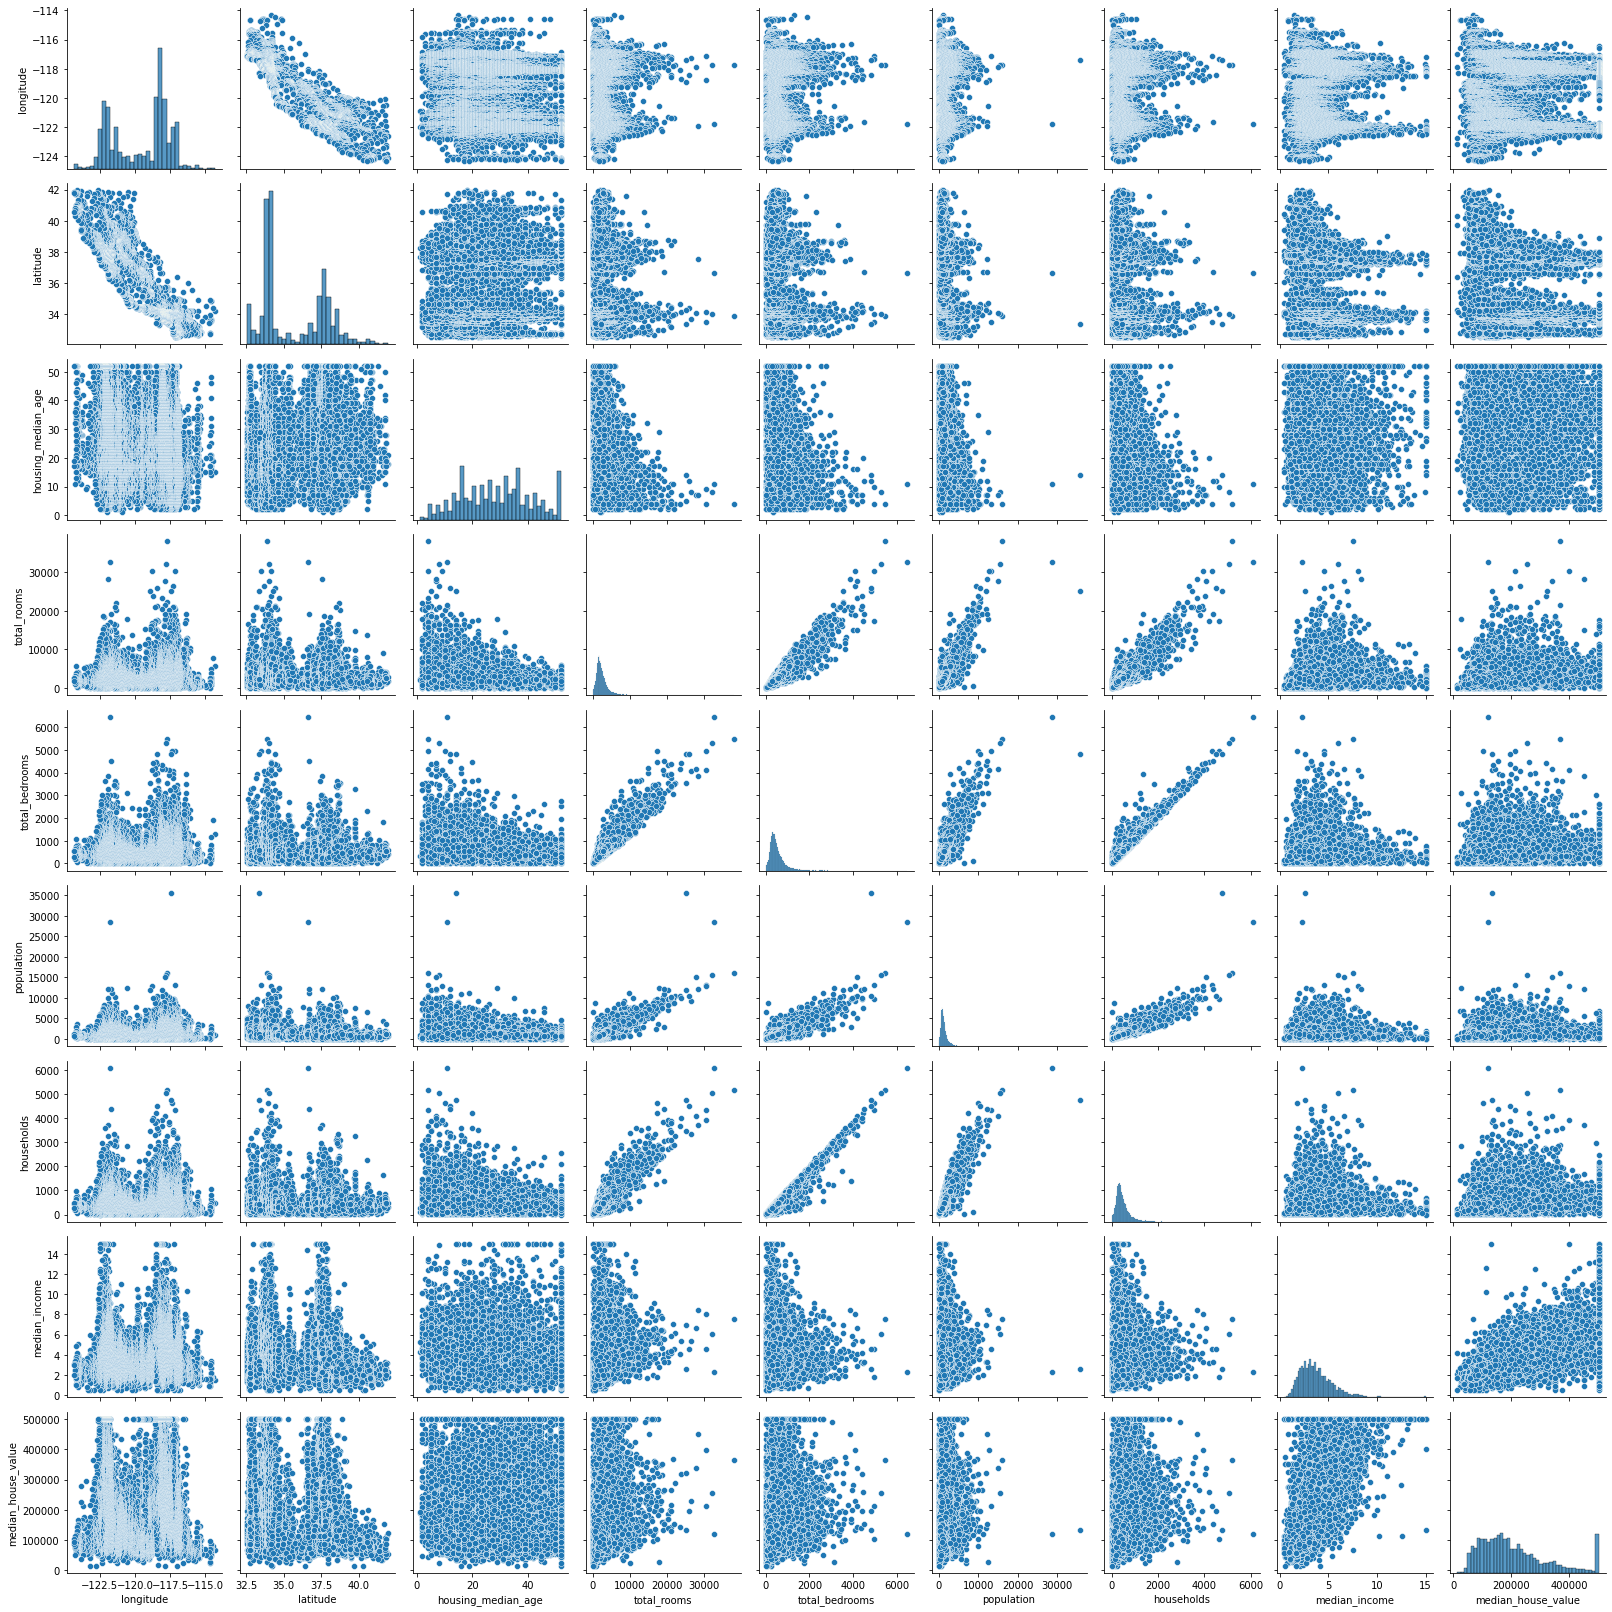

In [6]:
sns.pairplot(df[df.columns], height=2.5)
plt.tight_layout()
plt.show()

相關矩陣

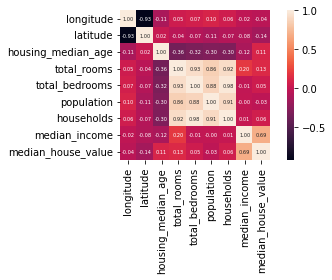

In [7]:
cm = np.corrcoef(df[df.columns].values.T)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size':5},
                 xticklabels=df.columns,
                 yticklabels=df.columns)
plt.tight_layout()
plt.show()

# Model

將數據集區分為訓練用&測試用

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [10]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# PCA

In [12]:
# 標準化資料
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
# PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.4890705 , 0.23849868, 0.134247  , 0.10241662, 0.01803461,
       0.010191  , 0.00581681, 0.00172478])

下圖可看出前4項主成分即可解釋9成的variance，故PCA的n_components可設為4。

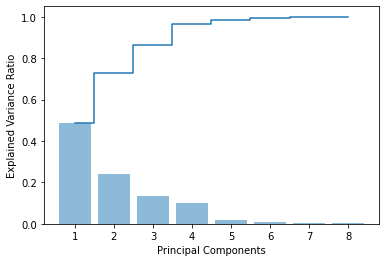

In [13]:
# 列出並排序所有特徵值
plt.bar(range(1,9), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1,9), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')

plt.show()

#模型: Decision Tree

In [14]:
lr = DecisionTreeRegressor(max_depth=11)

lr.fit(X_train, y_train.astype('int'))
y_pred = lr.predict(X_test)

print(f'預測房價: {y_pred}\n真實房價: {y_test}')
print(f'RMSE= {mean_squared_error(y_test, y_pred)}\nr2= {r2_score(y_test, y_pred)}')

預測房價: [279568.04081633 243973.07692308 240916.66666667 ... 337000.
  98620.         119325.        ]
真實房價: [288700. 275000. 263200. ... 228000. 153100.  98400.]
RMSE= 4018698295.779865
r2= 0.6949976097653168


In [40]:
# 沒有PCA的準度較高
pipe_lr = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                        StandardScaler(),
                        #PCA(n_components=0.9),
                        DecisionTreeRegressor(max_depth=11))

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.700


# 模型: Linear Rergression

In [16]:
pipe_lr = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'),
                        StandardScaler(),
                        #PCA(n_components=0.9),
                        LinearRegression())
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.660


# 模型: Random Forest Regressor

In [17]:
pipe_lr = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                        StandardScaler(),
                        #PCA(n_components=8),
                        RandomForestRegressor(
                           n_estimators=50,
                           criterion='mse',
                           random_state=1,
                           n_jobs=-1 
                        ))
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Test Accuracy: 0.828


# XGBoost Regressor

In [34]:
pipe_lr = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                        StandardScaler(),
                        #PCA(n_components=4),
                        XGBRegressor(
                            objective='reg:linear',
                            colsample_bytree=0.3,
                            n_estimators=50,
                            learning_rate=0.5,
                            max_depth=5,
                            alpha=10
                        ))
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test,y_test))

[07:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test Accuracy: 0.806


In [36]:
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=X, label=y)
param = {'objective':'reg:linear', 'colsample_bytree':0.3, 'learning_rate':0.5, 'max_depth':11, 'silent':1}

cv_result = xgb.cv(dtrain=data_dmatrix, params=param, nfold=3, num_boost_round=500, early_stopping_rounds=10, metrics='rmse', as_pandas=True, seed=1, verbose_eval=False)
print(cv_result)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0     145074.510417      211.630681   147515.276042     789.597685
1      95407.898437    10724.761629   101402.156250   10476.939317
2      74831.169271     8694.356787    85949.778646    9372.478358
3      61368.042969     9690.383346    76603.286458   12576.440316
4      52617.895833     3866.924035    71570.882813    7090.700700
5      49475.658854     4006.501771    71182.886718    6995.294307
6      44185.532552     4731.246216    69827.640625    7277.068422
7      40687.197917     5528.872617    68608.561198    8013.007909
8      36963.959635     7067.500493    66982.484375    9309.452156
9      34792.599609     6632.950299    66914.572916    9498.243106
10     32315.195964     6271.229505    66317.723958    9470.693521
11     30485.115885     5953.623211    66032.652344    9704.883826
12     27678.596354     5108.139092    65210.708333    9467.708847
13     26152.393880     4683.953983    65136.423177    9494.96

# 脊回歸 Ridge

In [43]:
from sklearn import linear_model

reg = linear_model.Ridge(alpha=.5)

reg.fit(X_train, y_train)
print('Ridge coef: ', reg.coef_)
print('Ridge intercept: ', reg.intercept_)

Ridge coef:  [-4.36828386e+04 -4.34144108e+04  1.10224547e+03 -7.68054113e+00
  1.17555602e+02 -3.68871676e+01  3.77575052e+01  4.01401716e+04]
Ridge intercept:  -3665493.815304423


# Lasso

In [46]:
from sklearn import linear_model

reg = linear_model.Lasso(alpha=.2)
reg.fit(X_train, y_train)
reg.predict(X_test)

array([269777.13363292, 293023.07653232, 270600.52239594, ...,
       304189.5560449 , 135080.0585143 , 145708.1189362 ])